# Fine-Tuning ChemBERTa


https://github.com/seyonechithrananda/bert-loves-chemistry/blob/master/chemberta/examples/ZINC250K_Transfer_Learning_With_HuggingFace_tox21.ipynb


## Libraries


In [61]:
import os
import shutil

import pickle

import ast
import numpy as np

import wandb

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import transformers
from transformers import Trainer, TrainingArguments

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers.modeling_outputs import SequenceClassifierOutput

import datasets
from datasets import load_from_disk
from datasets import concatenate_datasets
#from datasets import load_metric
# from evaluate import load # XXX

import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter1d

from huggingface_hub import login

from typing import Optional, Tuple

## Preamble


In [62]:
# 1. Choose model
MODEL_NAME = "DeepChem/ChemBERTa-5M-MTR"
MODEL_SUFFIX = MODEL_NAME.split("/")[1]


print(f"Model: {MODEL_NAME}")

Dataset: comp
Model: DeepChem/ChemBERTa-5M-MTR


## Datasets


In [63]:
# Dataset folder
DATASET_FOLDER_PATH = "/datasets"

In [64]:
## Need to use the keep_in_memory, because the dataset folder is in read-only
#Load exp datasets
train_dataset_exp = load_from_disk(os.path.join(DATASET_FOLDER_PATH, f"train_exp"), keep_in_memory=True)
val_dataset_exp = load_from_disk(os.path.join(DATASET_FOLDER_PATH, f"val_exp"), keep_in_memory=True)
test_dataset_exp = load_from_disk(os.path.join(DATASET_FOLDER_PATH, "test_exp"), keep_in_memory=True)

#Load comp datasets
train_dataset_comp = load_from_disk(os.path.join(DATASET_FOLDER_PATH, f"train_comp"), keep_in_memory=True)
val_dataset_comp = load_from_disk(os.path.join(DATASET_FOLDER_PATH, f"val_comp"), keep_in_memory=True)
test_dataset_comp = load_from_disk(os.path.join(DATASET_FOLDER_PATH, f"test_comp"), keep_in_memory=True)

In [65]:
#Preprocess Dataset
train_dataset_exp = train_dataset_exp.rename_column("spectrum", "labels")
val_dataset_exp = val_dataset_exp.rename_column("spectrum", "labels")
test_dataset_exp = test_dataset_exp.rename_column("spectrum", "labels")

train_dataset_comp = train_dataset_comp.rename_column("spectrum", "labels")
val_dataset_comp = val_dataset_comp.rename_column("spectrum", "labels")
test_dataset_comp = test_dataset_comp.rename_column("spectrum", "labels")

In [68]:
train_dataset_mix = concatenate_datasets([train_dataset_comp, train_dataset_exp])
val_dataset_mix = concatenate_datasets([val_dataset_comp, val_dataset_exp])

In [69]:
train_dataset_mix, val_dataset_mix

(Dataset({
     features: ['smiles', 'labels', 'base', 'shift'],
     num_rows: 116404
 }),
 Dataset({
     features: ['smiles', 'labels', 'base', 'shift'],
     num_rows: 14551
 }))

In [70]:
train_dataset_mix = train_dataset_mix.shuffle(seed=42)
val_dataset_mix = val_dataset_mix.shuffle(seed=42)

In [71]:
def truncate_spectrum_1(line):

    spectrum_truncated = line["labels"][0:800]
    line["labels"] = spectrum_truncated

    return line

In [72]:
def truncate_spectrum_2(line):

    spectrum_truncated = line["labels"][800:]
    line["labels"] = spectrum_truncated

    return line

In [73]:
train_dataset_mix_1 = train_dataset_mix.map(truncate_spectrum_1)
val_dataset_mix_1 = val_dataset_mix.map(truncate_spectrum_1)
test_dataset_comp_1 = test_dataset_comp.map(truncate_spectrum_1)
test_dataset_exp_1 = test_dataset_exp.map(truncate_spectrum_1)

Map:   0%|          | 0/116404 [00:00<?, ? examples/s]

Map:   0%|          | 0/14551 [00:00<?, ? examples/s]

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

In [74]:
train_dataset_mix_2 = train_dataset_mix.map(truncate_spectrum_2)
val_dataset_mix_2 = val_dataset_mix.map(truncate_spectrum_2)
test_dataset_comp_2 = test_dataset_comp.map(truncate_spectrum_2)
test_dataset_exp_2 = test_dataset_exp.map(truncate_spectrum_2)

Map:   0%|          | 0/116404 [00:00<?, ? examples/s]

Map:   0%|          | 0/14551 [00:00<?, ? examples/s]

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

## Tokenizer


In [75]:
# Models at https://huggingface.co/DeepChem

HF_TOKEN = "" #HF Login Token goes here

model_cache = "/storage/smiles2spec_models/"

In [76]:
login(HF_TOKEN)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [77]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir=model_cache)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [78]:
def tokenize(batch):
    
    tokens = tokenizer(batch['smiles'], 
                       truncation=True, 
                       padding=True, 
                       max_length=512)

    
    return tokens

In [79]:
train_dataset_mix_1 = train_dataset_mix_1.map(tokenize, batched=True)
val_dataset_mix_1 = val_dataset_mix_1.map(tokenize, batched=True)

test_dataset_comp_1 = test_dataset_comp_1.map(tokenize, batched=True)
test_dataset_exp_1 = test_dataset_exp_1.map(tokenize, batched=True)

Map:   0%|          | 0/116404 [00:00<?, ? examples/s]

Map:   0%|          | 0/14551 [00:00<?, ? examples/s]

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

In [80]:
train_dataset_mix_2 = train_dataset_mix_2.map(tokenize, batched=True)
val_dataset_mix_2 = val_dataset_mix_2.map(tokenize, batched=True)

test_dataset_comp_2 = test_dataset_comp_2.map(tokenize, batched=True)
test_dataset_exp_2 = test_dataset_exp_2.map(tokenize, batched=True)

Map:   0%|          | 0/116404 [00:00<?, ? examples/s]

Map:   0%|          | 0/14551 [00:00<?, ? examples/s]

Map:   0%|          | 0/8551 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

In [81]:
train_dataset_mix_1.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset_mix_1.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

test_dataset_comp_1.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset_exp_1.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [82]:
train_dataset_mix_2.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset_mix_2.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

test_dataset_comp_2.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset_exp_2.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [85]:
tokenizer.decode(train_dataset_mix_1[0]["input_ids"])

'[CLS]CCCCCC(O)=NCN=C(O)CCCCC[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]'

In [86]:
tokenizer.decode(train_dataset_mix_2[0]["input_ids"])

'[CLS]CCCCCC(O)=NCN=C(O)CCCCC[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]'

## Model


In [87]:
MODEL_NAME, MODEL_SUFFIX

('DeepChem/ChemBERTa-5M-MTR', 'ChemBERTa-5M-MTR')

In [88]:
num_labels = len(train_dataset_mix[0]["labels"])
num_labels

1801

In [91]:
class Smile2Spec(nn.Module):
    """A Smile2Spec model contains a LLM head, followed by a Feed Forward MLP."""
    def __init__(self, args):
        """
        Initializes the Smile2Spec model.
        :param args: argument for building the model."""

        super(Smile2Spec, self).__init__()

        #Create LLM head.
        self.LLM = AutoModelForSequenceClassification.from_pretrained(args.get('model_name'))

        #Create output objects.
        self.output_activation = args.get('output_activation')
        self.norm_range = args.get('norm_range')

        #Create FFN params.
        dropout = nn.Dropout(args.get('dropout'))
        activation = args.get('activation')

        # Create FFN layers
        if args.get('ffn_num_layers') == 1:
            ffn = [
                dropout,
                nn.Linear(args.get('ffn_input_dim'), args.get('ffn_output_dim'))
            ]
        else:
            ffn = [
                dropout,
                nn.Linear(args.get('ffn_input_dim'), args.get('ffn_hidden_size'))
            ]
            for _ in range(args.get('ffn_num_layers') - 2):
                ffn.extend([
                    activation,
                    dropout,
                    nn.Linear(args.get('ffn_hidden_size'), args.get('ffn_hidden_size'))
                ])
            ffn.extend([
                activation,
                dropout,
                nn.Linear(args.get('ffn_hidden_size'), args.get('ffn_output_dim'))
            ])

        self.ffn = nn.Sequential(*ffn)

    def forward(self,
                input_ids = None,
                attention_mask = None,
                labels=None):
        """
        Runs the Smile2Spec model on input.
        
        :return: Output of the Smile2Spec model."""

        #Compute LLM output.
        LLM_output = self.LLM(input_ids,
            attention_mask=attention_mask).logits # type: ignore

        #Compute ffn output.
        output = self.ffn(LLM_output)

        #Positive value mapping.
        if self.output_activation == 'exp':
            output = torch.exp(output)
        if self.output_activation == 'ReLU':
            f = nn.ReLU()
            output = f(output)

        #Normalization mapping.
        if self.norm_range is not None:
            norm_data = output[:, self.norm_range[0]:self.norm_range[1]]
            norm_sum = torch.sum(norm_data, 1)
            norm_sum = torch.unsqueeze(norm_sum, 1)
            output = torch.div(output, norm_sum)

        return output

In [94]:
class SIDLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, model_spectra, target_spectra):

        

        loss = torch.ones_like(target_spectra)

        loss = torch.mul(torch.log(torch.div(model_spectra, target_spectra)), model_spectra) \
                + torch.mul(torch.log(torch.div(target_spectra, model_spectra)), target_spectra)
        
        loss = torch.sum(loss, dim=1)

        return loss.mean()

## Training


In [95]:
NB_EPOCHS = 10
BATCH_SIZE = 64 # cf. seyonechithrananda
RESULTS_FOLDER = os.path.join(model_cache, f"{SUFFIX}/{MODEL_SUFFIX}")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-5M-MTR and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Model parameters

args_1 = {
    'model_name':MODEL_NAME,
    'output_activation':'exp',
    'norm_range':None,
    'dropout':0.2,
    'activation':nn.ReLU(),
    'ffn_num_layers':3,
    'ffn_input_dim':199,
    'ffn_hidden_size':2200,
    'ffn_output_dim':800,
    'ffn_num_layers':3
}

args_2 = {
    'model_name':MODEL_NAME,
    'output_activation':'exp',
    'norm_range':None,
    'dropout':0.2,
    'activation':nn.ReLU(),
    'ffn_num_layers':3,
    'ffn_input_dim':199,
    'ffn_hidden_size':2200,
    'ffn_output_dim':800,
    'ffn_num_layers':3
}

In [ ]:
model_1 = Smile2Spec(args_1)

In [96]:
model_2 = Smile2Spec(args_2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-5M-MTR and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [97]:
model_1

Smile2Spec(
  (LLM): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(600, 384, padding_idx=1)
        (position_embeddings): Embedding(515, 384, padding_idx=1)
        (token_type_embeddings): Embedding(1, 384)
        (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.144, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-2): 3 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=384, out_features=384, bias=True)
                (key): Linear(in_features=384, out_features=384, bias=True)
                (value): Linear(in_features=384, out_features=384, bias=True)
                (dropout): Dropout(p=0.109, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linea

In [98]:
total_params = sum(p.numel() for p in model_1.parameters())
total_trainable_params = sum(p.numel() for p in model_1.parameters() if p.requires_grad)

print("Total Params. : ", f"{total_params:,}")
print("Total Trainable Params. : ", f"{total_trainable_params:,}")

Total Params. :  15,389,255
Total Trainable Params. :  15,389,255


In [99]:
# New loss will be implemented here

class CustomTrainer(Trainer):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
   
    def compute_loss(self, model, inputs, return_outputs=False):
        
        labels = inputs.get("labels")
        outputs = model(**inputs)
        loss_fct = SIDLossFinal()
        loss = loss_fct(outputs, labels)
        
        return (loss, {"label": outputs}) if return_outputs else loss

In [100]:
training_args = TrainingArguments(
    
    # output
    output_dir=RESULTS_FOLDER,          
    
    # params
    num_train_epochs=NB_EPOCHS,               # nb of epochs
    per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,    # cf. paper Sun et al.
    learning_rate=5e-5, #2e-5,                # cf. seyonechithrananda / cf. paper Sun et al.
#     warmup_steps=500,                         # number of warmup steps for learning rate scheduler
    warmup_ratio=0.1,                         # cf. paper Sun et al.
    weight_decay=0.01,                        # strength of weight decay
    
    # eval
    evaluation_strategy="steps",              # cf. paper Sun et al.
    eval_steps=200,                           # cf. paper Sun et al.
    
    # log
    logging_dir=RESULTS_FOLDER+'logs',  
    logging_strategy='steps',
    logging_steps=200,
    
    # save
    save_strategy='steps',
    save_total_limit=2,
    save_steps=200,                           # save model at every eval (default 500)
    load_best_model_at_end=True,              # cf. paper Sun et al.
    metric_for_best_model='eval_loss',
    # metric_for_best_model='mse', # XXX
    
    report_to="none",                         # "wandb" or "none" to turn wandb off!
    # run_name=f"{model_suffix}",               # name of the W&B run (optional)

    remove_unused_columns=False
)

In [101]:
trainer_1 = CustomTrainer(
    model=model_1,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=train_dataset_mix_1,
    eval_dataset=val_dataset_mix_1
)

In [102]:
results = trainer_1.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
200,1.716600,1.243177
400,0.706400,0.619931
600,0.604100,0.501507
800,0.437400,0.389767
1000,0.386700,0.368827
1200,0.371200,0.350541
1400,0.429300,0.316776
1600,0.321000,0.298798
1800,0.303700,0.284880
2000,0.288800,0.275472


In [103]:
trainer_2 = CustomTrainer(
    model=model_2,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=train_dataset_mix_2,
    eval_dataset=val_dataset_mix_2
)

In [104]:
results_2 = trainer_2.train()

Step,Training Loss,Validation Loss
200,9487.817500,8320.884766
400,1815.629500,0.347060
600,0.336600,0.330842
800,0.281400,0.321363
1000,0.285800,0.297334
1200,0.388400,0.258450
1400,0.337700,0.221497
1600,0.318900,0.203665
1800,0.197300,0.187927
2000,0.195000,0.183515


In [105]:
# save history (loss)
with open(os.path.join(RESULTS_FOLDER, "log_history.pkl"), "wb") as fh:

    pickle.dump(trainer_1.state.log_history, fh)

## Fine-Tune


## Results


In [106]:
model_1.eval()
model_2.eval()

Smile2Spec2(
  (LLM): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(600, 384, padding_idx=1)
        (position_embeddings): Embedding(515, 384, padding_idx=1)
        (token_type_embeddings): Embedding(1, 384)
        (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.144, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-2): 3 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=384, out_features=384, bias=True)
                (key): Linear(in_features=384, out_features=384, bias=True)
                (value): Linear(in_features=384, out_features=384, bias=True)
                (dropout): Dropout(p=0.109, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Line

In [107]:
predicts_comp_1 = trainer_1.predict(test_dataset_comp_1)
predicts_exp_1 = trainer_1.predict(test_dataset_exp_1)

In [108]:
predicts_comp_2 = trainer_2.predict(test_dataset_comp_2)
predicts_exp_2 = trainer_2.predict(test_dataset_exp_2)

In [109]:
test_preds_comp_1, test_truths_comp_1 = predicts_comp_1.predictions, predicts_comp_1.label_ids
test_preds_exp_1, test_truths_exp_1 = predicts_exp_1.predictions, predicts_exp_1.label_ids

In [110]:
test_preds_comp_2, test_truths_comp_2 = predicts_comp_2.predictions, predicts_comp_2.label_ids
test_preds_exp_2, test_truths_exp_2 = predicts_exp_2.predictions, predicts_exp_2.label_ids

In [111]:
predicts_comp_1[0]

array([[5.5121863e-04, 5.4261094e-04, 5.3742441e-04, ..., 1.8141933e-05,
        1.7552913e-05, 1.6060145e-05],
       [5.4928084e-04, 5.3482578e-04, 5.7401956e-04, ..., 2.4615749e-05,
        2.3320117e-05, 2.1081847e-05],
       [7.4785133e-04, 7.6623022e-04, 7.5742690e-04, ..., 1.6647720e-05,
        1.7463231e-05, 1.4824386e-05],
       ...,
       [6.8123278e-04, 6.9368922e-04, 6.8756816e-04, ..., 3.1923675e-05,
        3.2205855e-05, 2.7417931e-05],
       [3.8788444e-04, 3.7311105e-04, 3.7834886e-04, ..., 9.6795466e-06,
        8.8185398e-06, 8.0258924e-06],
       [5.1153544e-04, 5.3216913e-04, 5.3564197e-04, ..., 2.0764046e-05,
        2.0516385e-05, 1.8343282e-05]], dtype=float32)

In [112]:
print(test_preds_comp_1.shape)
print(test_truths_comp_1.shape)
print(test_preds_comp_2.shape)
print(test_truths_comp_2.shape)
print(test_preds_exp_1.shape)
print(test_truths_exp_1.shape)
print(test_preds_exp_2.shape)
print(test_truths_exp_2.shape)

(8551, 800)
(8551, 800)
(8551, 1001)
(8551, 1001)
(6000, 800)
(6000, 800)
(6000, 1001)
(6000, 1001)


In [113]:
test_preds_comp_1[0].shape

(800,)

In [114]:
test_preds_comp = np.concatenate((test_preds_comp_1, test_preds_comp_2), axis =1)
test_truths_comp = np.concatenate((test_truths_comp_1, test_truths_comp_2), axis = 1)

test_preds_exp = np.concatenate((test_preds_exp_1, test_preds_exp_2), axis =1)
test_truths_exp = np.concatenate((test_truths_exp_1, test_truths_exp_2), axis = 1)

In [115]:
# save results

torch.save(test_preds_comp, os.path.join(RESULTS_FOLDER,'test_preds_comp.pt'))
torch.save(test_truths_comp, os.path.join(RESULTS_FOLDER,'test_truths_comp.pt'))

torch.save(test_preds_exp, os.path.join(RESULTS_FOLDER,'test_preds_exp.pt'))
torch.save(test_truths_exp, os.path.join(RESULTS_FOLDER,'test_truths_exp.pt'))

In [117]:
# load results if necessary

test_preds_comp = torch.load(os.path.join(RESULTS_FOLDER,'test_preds_comp.pt'))
test_truths_comp = torch.load(os.path.join(RESULTS_FOLDER,'test_truths_comp.pt'))

test_preds_exp = torch.load(os.path.join(RESULTS_FOLDER,'test_preds_exp.pt'))
test_truths_exp = torch.load(os.path.join(RESULTS_FOLDER,'test_truths_exp.pt'))

In [118]:
test_dataset_comp

Dataset({
    features: ['smiles', 'labels'],
    num_rows: 8551
})

In [119]:
def SIDScore(predicted_spectrum, true_spectrum):

    #Gaussian Convolution
    predicted_spectrum_conv = gaussian_filter1d(predicted_spectrum, 5)
    true_spectrum_conv = gaussian_filter1d(true_spectrum, 5)

    #Normalization
    predicted_spectrum_conv = nn.functional.normalize(torch.tensor(predicted_spectrum_conv).reshape(1, -1), p=1)
    true_spectrum_conv = nn.functional.normalize(torch.tensor(true_spectrum_conv).reshape(1, -1), p=1)
    
    #Initialize SID Class
    SID = SIDLoss()
    
    sid = SID(predicted_spectrum_conv, true_spectrum_conv)

    return 1/(1+sid)

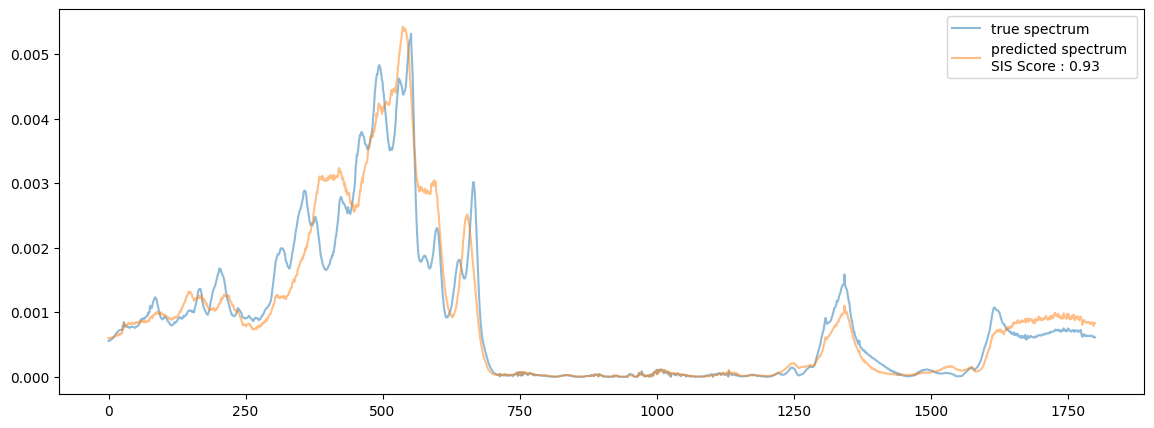

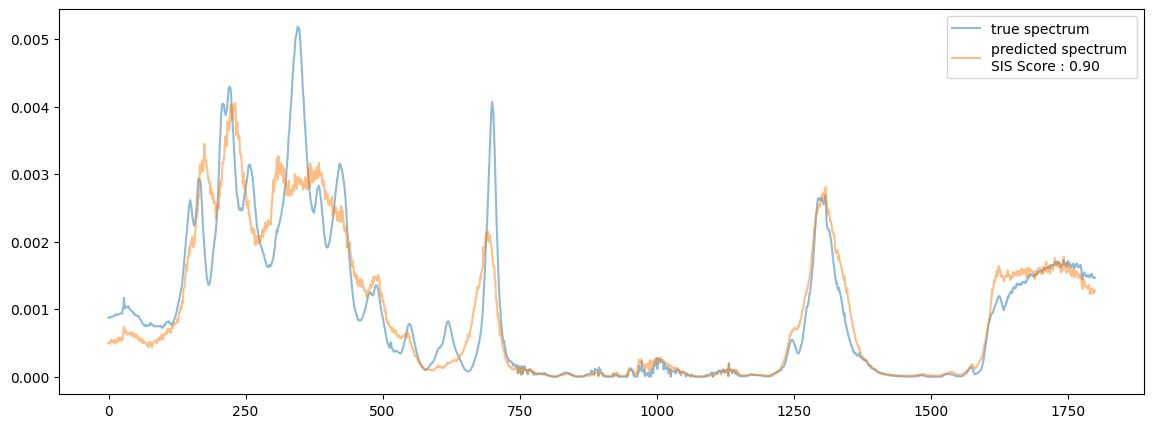

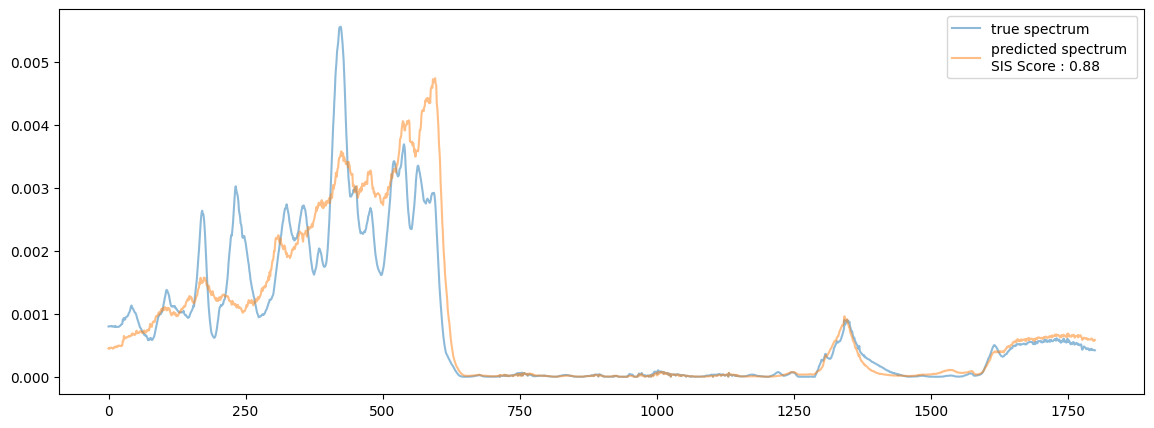

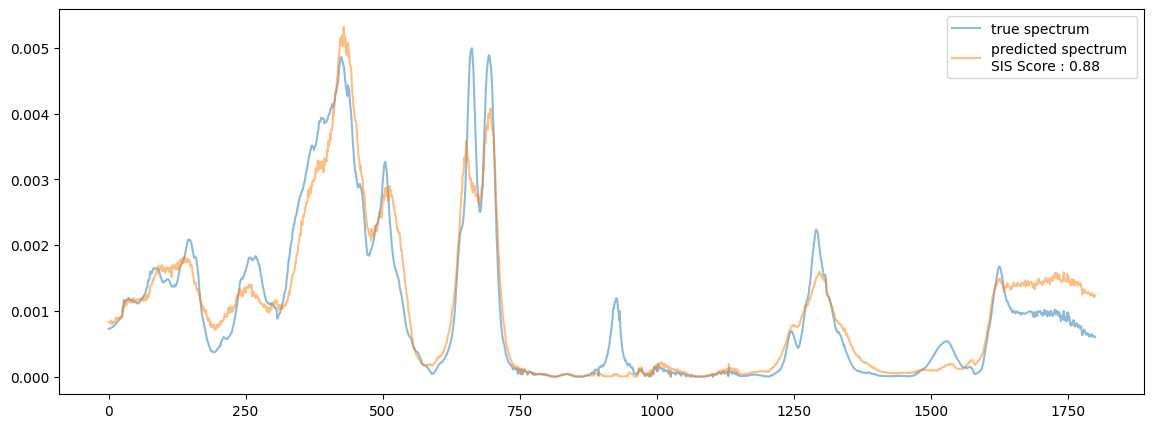

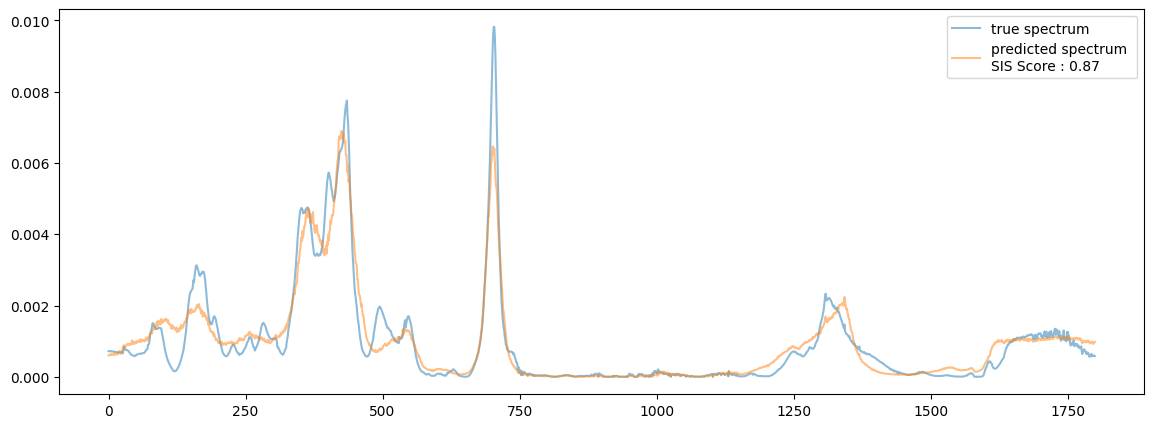

In [120]:
for i in np.random.choice(8551, 5):
    
    plt.figure(figsize=(14, 5))

    spectrum_truth = test_truths_comp[i, :]
    spectrum_pred = test_preds_comp[i, :]

    sis_score = SIDScore(spectrum_pred, spectrum_truth)

    plt.plot(range(len(spectrum_truth)), spectrum_truth, label="true spectrum", alpha=0.5)

    spectrum_pred_smooth = gaussian_filter1d(spectrum_pred, 5)

    plt.plot(range(len(spectrum_pred)), spectrum_pred, label=f"predicted spectrum \nSIS Score : {sis_score:.2f}", alpha=0.5)
    
    plt.legend()
    plt.show()

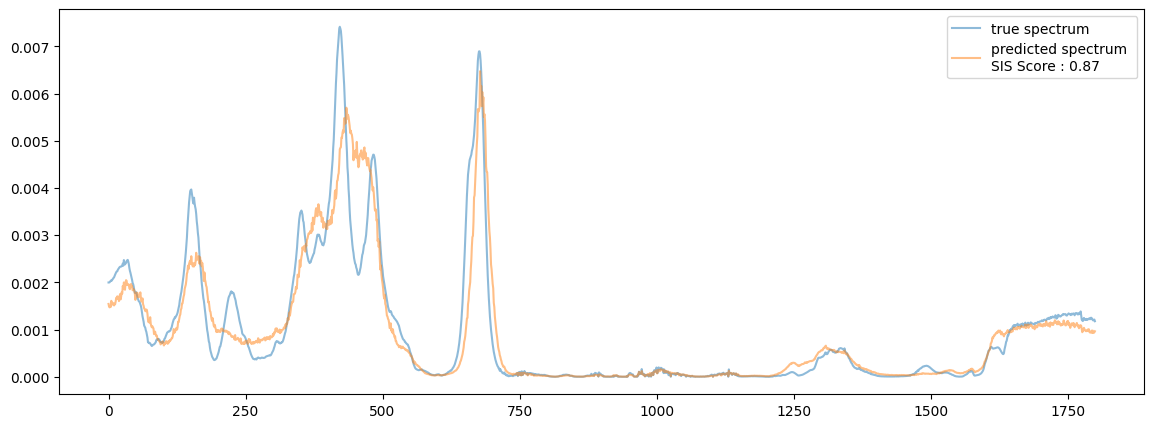

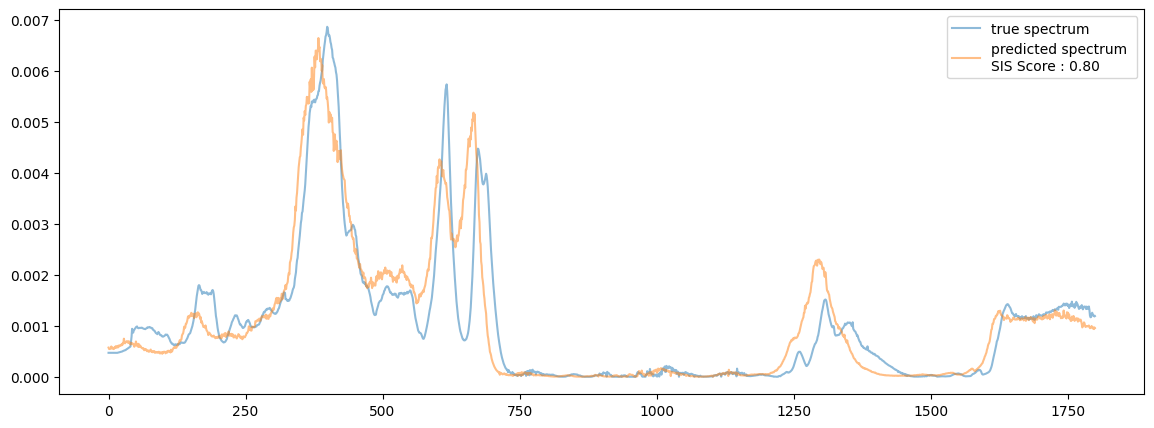

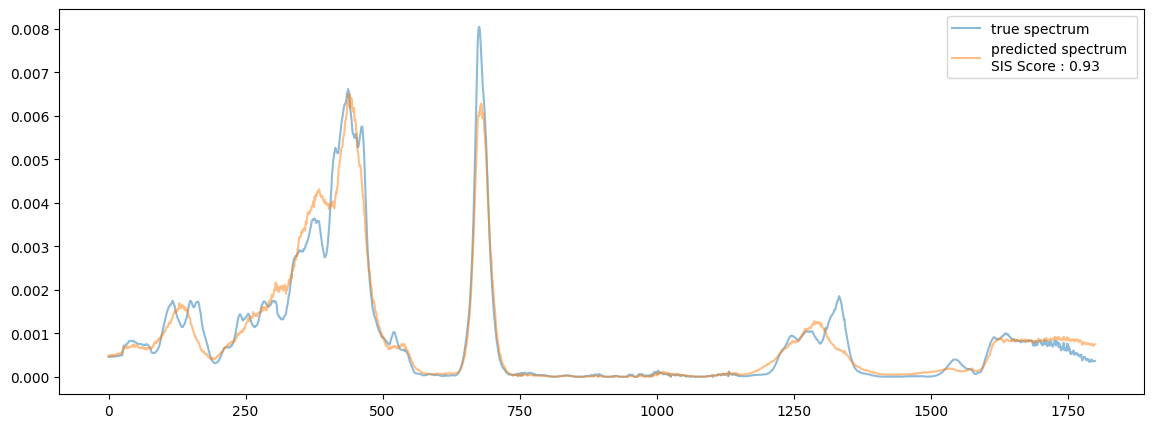

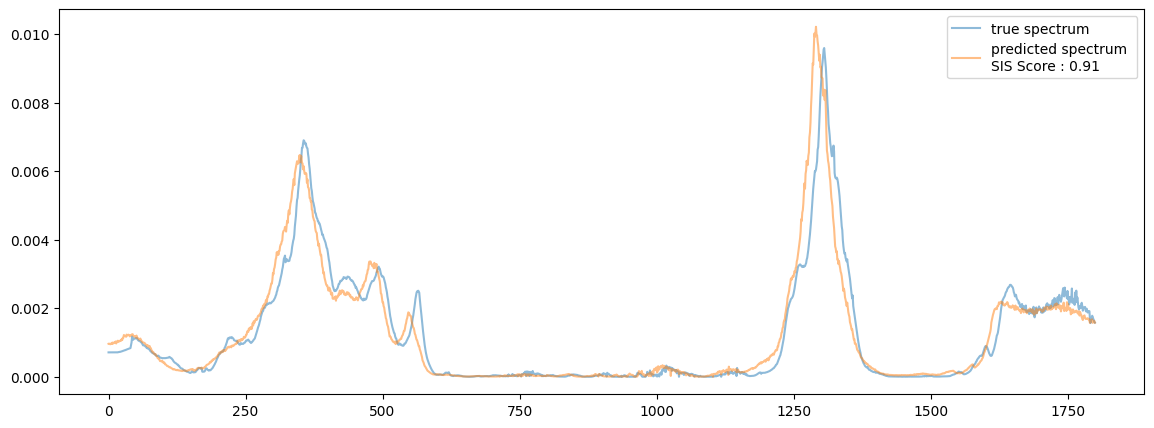

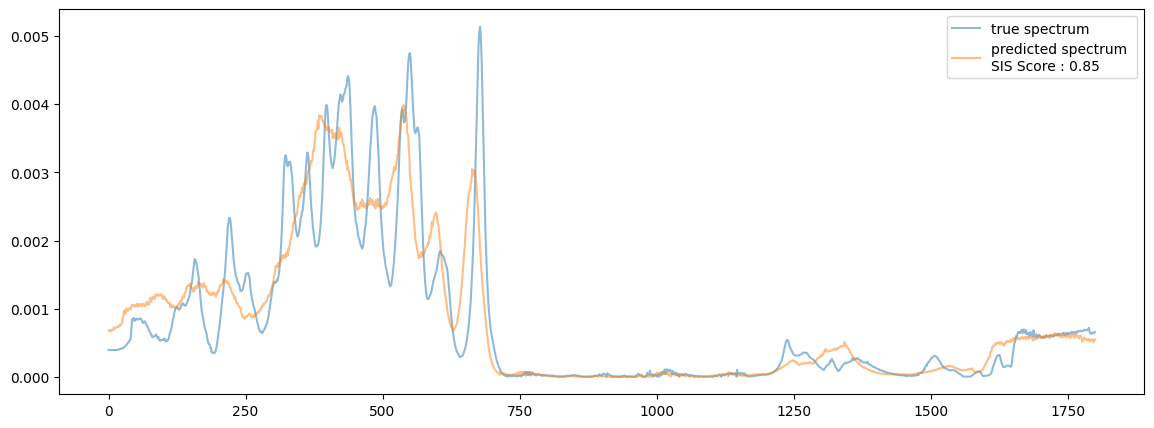

In [121]:
for i in np.random.choice(6000, 5):
    
    plt.figure(figsize=(14, 5))

    spectrum_truth = test_truths_exp[i, :]
    spectrum_pred = test_preds_exp[i, :]

    sis_score = SIDScore(spectrum_pred, spectrum_truth)

    plt.plot(range(len(spectrum_truth)), spectrum_truth, label="true spectrum", alpha=0.5)

    spectrum_pred_smooth = gaussian_filter1d(spectrum_pred, 5)

    plt.plot(range(len(spectrum_pred)), spectrum_pred, label=f"predicted spectrum \nSIS Score : {sis_score:.2f}", alpha=0.5)
    
    plt.legend()
    plt.show()